# Сегментация объектов

### Загрузка датасета COCO и кода COCO API

In [ ]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && wget http://images.cocodataset.org/zips/val2017.zip
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
!cd data && unzip -q train2017.zip
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip

!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

### Импорт необходимых библиотек

In [ ]:
import os
import skimage.io as io
import numpy as np

### Импорт TensorFlow

In [ ]:
# !pip install tensorflow==2.1

In [ ]:
import tensorflow as tf
tf.__version__

'2.1.0'

### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [ ]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        # https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=26.87s)
creating index...
index created!
loading annotations into memory...
Done (t=0.94s)
creating index...
index created!


In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 1
INP_SIZE = 128

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

In [ ]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out
    
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(1028, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(1028, (3, 3), padding='same', activation='relu')

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        self.unpool = tf.keras.layers.UpSampling2D((2, 2))

        self.conv11 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')

        self.conv15 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv16 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv17 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.aspp = ASPPBlock()

    def call(self, x):

        out1 = self.conv1(x)
        out = self.conv2(out1)
        out = self.maxpool(out)

        out2 = self.conv3(out)
        out = self.conv4(out2)
        out = self.maxpool(out)

        out3 = self.conv5(out)
        out = self.conv6(out3)
        out = self.maxpool(out)

        out4 = self.conv7(out)
        out = self.conv8(out4)
        out = self.maxpool(out)

        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)
        
        out = self.unpool(out)
        out = self.conv11(out)
        out = tf.concat([out4, out], axis=3)

        out = self.unpool(out)
        out = self.conv12(out)
        out = tf.concat([out3, out], axis=3)

        out = self.unpool(out)
        out = self.conv13(out)
        out = tf.concat([out2, out], axis=3)

        out = self.unpool(out)
        out = self.conv14(out)
        out = tf.concat([out1, out], axis=3)

        out = self.conv15(out)
        out = self.conv16(out)
        out = self.conv17(out)

        out = tf.nn.sigmoid(out)
        return out
    
model = ASPPNet()

In [ ]:
! pip install livelossplot

In [ ]:
from livelossplot.inputs.tf_keras import PlotLossesCallback

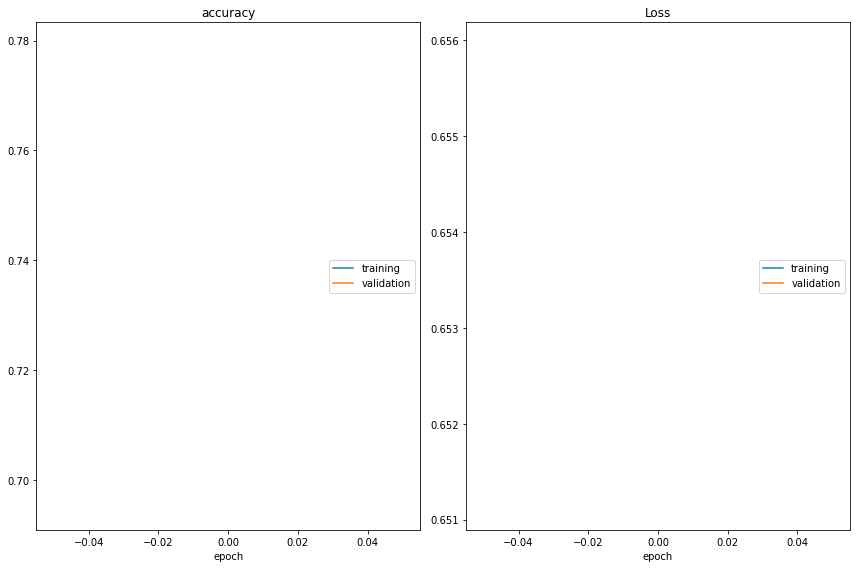

accuracy
	training         	 (min:    0.779, max:    0.779, cur:    0.779)
	validation       	 (min:    0.695, max:    0.695, cur:    0.695)
Loss
	training         	 (min:    0.656, max:    0.656, cur:    0.656)
	validation       	 (min:    0.651, max:    0.651, cur:    0.651)
25/25 [==============================] - 7618s 305s/step - loss: 0.6559 - accuracy: 0.7791 - val_loss: 0.6511 - val_accuracy: 0.6952


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_ds, steps_per_epoch=25, epochs=NUM_EPOCHS, validation_data=val_ds, callbacks=[PlotLossesCallback()])

In [ ]:
import random
import imageio
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
# tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


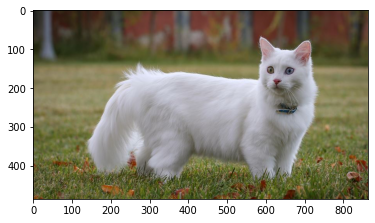

In [ ]:
img = imageio.imread('cat.jpg')
img = img.astype(np.float32) / 255.
# img = np.expand_dims(img, axis=0)
_=plt.imshow(img)

In [ ]:
img.shape

(486, 864, 3)

In [ ]:
img = tf.image.resize(img, (256, 256), tf.image.ResizeMethod.BILINEAR)
img.shape

TensorShape([256, 256, 3])

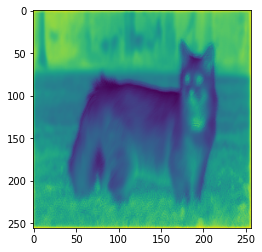

In [ ]:
out = model.predict(img[None, ...])[0, ...]
_=plt.imshow(out[..., 0])

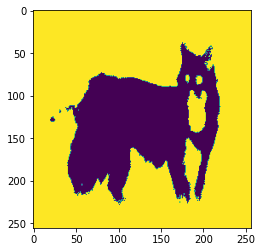

In [ ]:
seg_map = (out[..., 0]>0.43).astype(np.float32)
_=plt.imshow(seg_map)

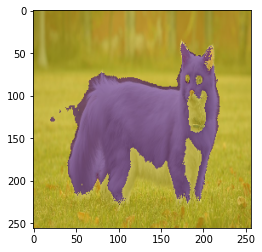

In [ ]:
seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
plt.imshow(img*0.5 + seg_map_clr*0.5)
plt.show()